In [1]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.2 MB/s eta 0:00:00


In [17]:
from langchain_community.llms import Replicate
from google.colab import userdata
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
os.environ['REPLICATE_API_TOKEN'] = userdata.get('api_token')

In [3]:
# Set model parameters
parameters = {
  "top_k": 5, #good to keep it focused but still allows some variation
  "top_p": 0.9, #more precise and controlled answers
  "max_tokens": 1024,
  "min_tokens": 50, #prevent ultra short output
  "random_seed": 42,
  "repetition_penalty": 1.2, #avoid repetitibe phhrase
  "temperature": 0.5,
  "stopping_criteria": None,
  "stopping_sequence": None
}

In [4]:
# Initialize Granite model
llm = Replicate(
  model="ibm-granite/granite-3.3-8b-instruct",
  input=parameters,
)

#Dataset

I collected the dataset myself by scraping Bromo Mount reviews from Google Maps

In [5]:
file_path = "/content/IBMGBROMO.xlsx"
df = pd.read_excel(file_path)

In [6]:
print("Sample data:")
print(df.head())

Sample data:
               Reviewer Rating  \
0  Victoria Adeline Ayu    5,0   
1                  Aqey    5,0   
2   Syarif Hidayatullah    5,0   
3         zannu fathony    5,0   
4             Nadia Ayu    5,0   

                                              Review  
0  dingin banget hawanya..suwejuk..anginnya juga ...  
1  Nungguin sunrise di atas dari jam 4 ampe jam 5...  
2  Bromo, gunung yg bisa didaki oleh orang awam, ...  
3  pemandangan matahari terbit yang menakjubkan, ...  
4  Tempat terbaik yang pernah ada. Dingin, sejuk,...  


## LLM

For each review, i’ll ask IBM Granite to extract:

1. Sentiment — Positive / Negative / Mixed
2. Summary
3. Mentioned Aspects — e.g., location, service, cleanliness
4. Complaints (if any) — Specific problems
5. Recommendation — What the management should improve/do

In [34]:
# LLM analysis function
def analyze_review(review_text):
  prompt = f"""
You are an AI travel analyst.

Analyze the following Gunung Bromo review:

\"\"\"{review_text}\"\"\"

1. Sentiment - Positive, Negative, or Mixed.
2. Summarize the main point of the review.
3. List specific things mentioned, like cleanliness, location, and service
4. List any complaints mentioned; if none, write "None"
5. Give one actionable recommendation for the management.

Respond in this exact format:
Sentiment: ...
Summary: ...
Things Mentioned (Praises): ...
Complaints: ...
Praises: ...
Recommendation: ...
  """
  output = llm.invoke(prompt)
  return output

In [35]:
# Apply to 2 random reviews
for i, row in df.sample(n=2, random_state=None).iterrows():
  print("==============================================")
  print(f"Original Review:\n{row['Review']}\n")
  result = analyze_review(row['Review'])
  print("AI Analysis:\n", result)
  print("==============================================\n")


Original Review:
Gunung berapi aktif yang luar biasa.
Tamasya jip saat matahari terbit, terlalu padat untuk seleraku...
Menunggang kuda yang sangat menyenangkan di kaldera

AI Analysis:
 Sentiment: Positive
Summary: The review expresses a highly positive experience with an active volcano, Gunung Bromo. The reviewer highlights the thrilling horseback riding adventure in the caldera during sunrise, describing it as an extraordinary and crowded event.

Things Mentioned (Praises):
- Active volcano (Gunung Bromo)
- Unique sunrise tamu (crowd) experience
- Thrilling horseback riding in the caldera

Complaints: None

Praises:
- The extraordinary nature of the active volcano
- The packed, lively atmosphere during sunrise
- The enjoyable horseback riding experience in the caldera

Recommendation: To maintain this positive sentiment, the management should ensure consistent safety measures and possibly regulate the number of visitors during peak times like sunrise to prevent overcrowding and enha

## Analysis

In [36]:
#Parse analysis results
def parse_analysis(text):
    result = {
        'Sentiment': None,
        'Summary': None,
        'Things Mentioned': None,
        'Complaints': None,
        'Praises': None
    }

    current_key = None
    for line in text.split('\n'):
        line = line.strip()
        if line.startswith('Sentiment:'):
            current_key = 'Sentiment'
            result[current_key] = line.split(':', 1)[1].strip()
        elif line.startswith('Summary:'):
            current_key = 'Summary'
            result[current_key] = line.split(':', 1)[1].strip()
        elif line.startswith('Things Mentioned:'):
            current_key = 'Things Mentioned'
            result[current_key] = line.split(':', 1)[1].strip()
        elif line.startswith('Complaints:'):
            current_key = 'Complaints'
            result[current_key] = line.split(':', 1)[1].strip()
        elif line.startswith('Praises:'):
            current_key = 'Praises'
            result[current_key] = line.split(':', 1)[1].strip()
        elif current_key and line:  # Handle multi-line values if it can
            result[current_key] += " " + line

    # Clean up the results
    for key in result:
        if result[key] and isinstance(result[key], str):
            result[key] = result[key].strip()
            if result[key].lower() == 'none':
                result[key] = None

    return result

In [37]:
# Analyze all reviews (or a sample for testing)
analysis_results = []
sample_size = min(250, len(df))  # Adjust sample size as needed and mine data is not too large around 400ish
for i, row in tqdm(df.sample(n=sample_size, random_state=42).iterrows(), total=sample_size):
    try:
        output = analyze_review(row['Review'])
        parsed = parse_analysis(output)
        analysis_results.append(parsed)
    except Exception as e:
        print(f"Error processing review {i}: {e}")
        continue

100%|██████████| 250/250 [08:31<00:00,  2.04s/it]


In [38]:
# Convert to DataFrame
results_df = pd.DataFrame(analysis_results)

In [39]:
# Sentiment Analysis
sentiment_counts = results_df['Sentiment'].value_counts(normalize=True) * 100
sentiment_data = {
    'Positive': sentiment_counts.get('Positive', 0),
    'Negative': sentiment_counts.get('Negative', 0),
    'Mixed': sentiment_counts.get('Mixed', 0)
}


In [40]:
# Complaint/Praise Analysis
def categorize_review(row):
    has_complaint = row['Complaints'] != 'None' and pd.notna(row['Complaints'])
    has_praise = row['Praises'] != 'None' and pd.notna(row['Praises'])

    if has_complaint and has_praise:
        return 'Both'
    elif has_complaint:
        return 'Only Complaints'
    elif has_praise:
        return 'Only Praises'
    else:
        return 'Neither'

results_df['Category'] = results_df.apply(categorize_review, axis=1)
category_counts = results_df['Category'].value_counts(normalize=True) * 100

In [82]:
# Wrd frequency analysis
def get_word_freq(text_series, min_word_length=3, top_n=10):
    word_freq = defaultdict(int)
    stop_words = {'the', 'and', 'was', 'were', 'that', 'this', 'with', 'for', 'have', 'has', 'had', 'none', 'not', 'from', 'during', 'reviewer',
        'explicitly', 'lack', 'due', 'consider', 'visitor', 'could', 'visitors', 'management', 'recommendation', 'recommendations', 'more', 'positive', 'experience',
                  'enhance', 'mount','ensuring', 'should', 'continue','ensure'}

    for text in text_series:
        if pd.notna(text) and text not in [None, 'None', '']:
            # Extract words more carefully
            words = re.findall(r'\b[\w\-]+\b', text.lower())
            for word in words:
                if (len(word) >= min_word_length and
                    word not in stop_words and
                    not word.isnumeric()):
                    word_freq[word] += 1

    return sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

top_complaints = get_word_freq(results_df['Complaints'])
top_praises = get_word_freq(results_df['Praises'])

In [83]:
# Generate Insights
def generate_insights():
    insights = []

    # Sentiment insights
    insights.append("● Sentiment Analysis:")
    insights.append(f"- Positive reviews: {sentiment_data['Positive']:.1f}%")
    insights.append(f"- Negative reviews: {sentiment_data['Negative']:.1f}%")
    insights.append(f"- Mixed reviews: {sentiment_data['Mixed']:.1f}%")

    # Category insights
    insights.append("\n● Review Categories:")
    for category, percentage in category_counts.items():
        insights.append(f"- {category}: {percentage:.1f}%")

    # Top complaints
    insights.append("\n● Top Complaint Themes:")
    if top_complaints:
        for word, count in top_complaints:
            insights.append(f"- {word.capitalize()} ({count} mentions)")
    else:
        insights.append("- No significant complaints identified")

    # Top praises
    insights.append("\n● Top Praise Themes:")
    if top_praises:
        for word, count in top_praises:
            insights.append(f"- {word.capitalize()} ({count} mentions)")
    else:
        insights.append("- No explicit praises identified in the sample")

        # Fallback to positive sentiment analysis
        if sentiment_data['Positive'] > 0:
            insights.append(f"  Note: {sentiment_data['Positive']:.1f}% of reviews were positive but didn't contain specific praise words")
            insights.append("  Consider refining the praise extraction prompt or examining positive reviews manually")

    # Things mentioned
    all_things = []
    for things in results_df['Things Mentioned'].dropna():
        if things not in [None, 'None', '']:
            all_things.extend([t.strip().lower() for t in str(things).split(',')])

    if all_things:
        thing_counts = pd.Series(all_things).value_counts().head(10)
        insights.append("\n● Most Frequently Mentioned Aspects:")
        for thing, count in thing_counts.items():
            insights.append(f"- {thing.capitalize()} ({count} mentions)")
    else:
        insights.append("\n● No specific aspects were frequently mentioned")

    return '\n'.join(insights)

In [84]:
# Generate Recommendations
def generate_recommendations():
    recommendations = []

    # Based on sentiment
    if sentiment_data['Positive'] > 50:
        recommendations.append("● Leverage the positive sentiment ({}%) in marketing materials.".format(sentiment_data['Positive']))
    if sentiment_data['Negative'] > 20:
        recommendations.append("● Address negative feedback as it represents a significant portion ({:.1f}%) of reviews.".format(sentiment_data['Negative']))

    # Based on praises
    if top_praises:
        main_praise = top_praises[0][0]
        recommendations.append(f"● Highlight '{main_praise}' in your marketing as it's the most common positive aspect.")
    elif sentiment_data['Positive'] > 0:
        recommendations.append("● Analyze positive reviews manually to identify common praise themes that weren't automatically detected.")

    # Based on complaints
    if top_complaints:
        main_complaint = top_complaints[0][0]
        recommendations.append(f"● Focus on improving '{main_complaint}' as it's the most common complaint.")

    # General recommendations
    recommendations.append("● Consider implementing a structured feedback system to better capture positive and negative aspects.")
    recommendations.append("● Train staff to encourage guests to provide specific feedback about what they enjoyed.")
    recommendations.append("● If praise detection remains low, manually analyze a subset of positive reviews to improve the AI's extraction capability.")

    return '\n'.join(recommendations)

## Results

In [85]:
# Display results
print("="*80)
print("COMPREHENSIVE REVIEW ANALYSIS".center(80))
print("="*80)
print(f"\nTotal Reviews Analyzed: {len(results_df)}")
print("\n" + generate_insights())

print("\n" + "="*80)
print("STRATEGIC RECOMMENDATIONS".center(80))
print("="*80)
print("\n" + generate_recommendations())

                         COMPREHENSIVE REVIEW ANALYSIS                          

Total Reviews Analyzed: 250

● Sentiment Analysis:
- Positive reviews: 86.0%
- Negative reviews: 0.8%
- Mixed reviews: 13.2%

● Review Categories:
- Only Praises: 73.2%
- Both: 26.8%

● Top Complaint Themes:
- Sunrise (7 mentions)
- Fog (6 mentions)
- Facilities (5 mentions)
- High (5 mentions)
- Toilet (5 mentions)
- Cold (5 mentions)
- Conditions (5 mentions)
- Horse (4 mentions)
- Weather (4 mentions)
- Stated (4 mentions)

● Top Praise Themes:
- Bromo (218 mentions)
- Gunung (174 mentions)
- Beauty (145 mentions)
- Sunrise (115 mentions)
- Natural (111 mentions)
- Unique (100 mentions)
- Maintain (97 mentions)
- Breathtaking (58 mentions)
- View (58 mentions)
- Views (57 mentions)

● No specific aspects were frequently mentioned

                           STRATEGIC RECOMMENDATIONS                            

● Leverage the positive sentiment (86.0%) in marketing materials.
● Highlight 'bromo' in you

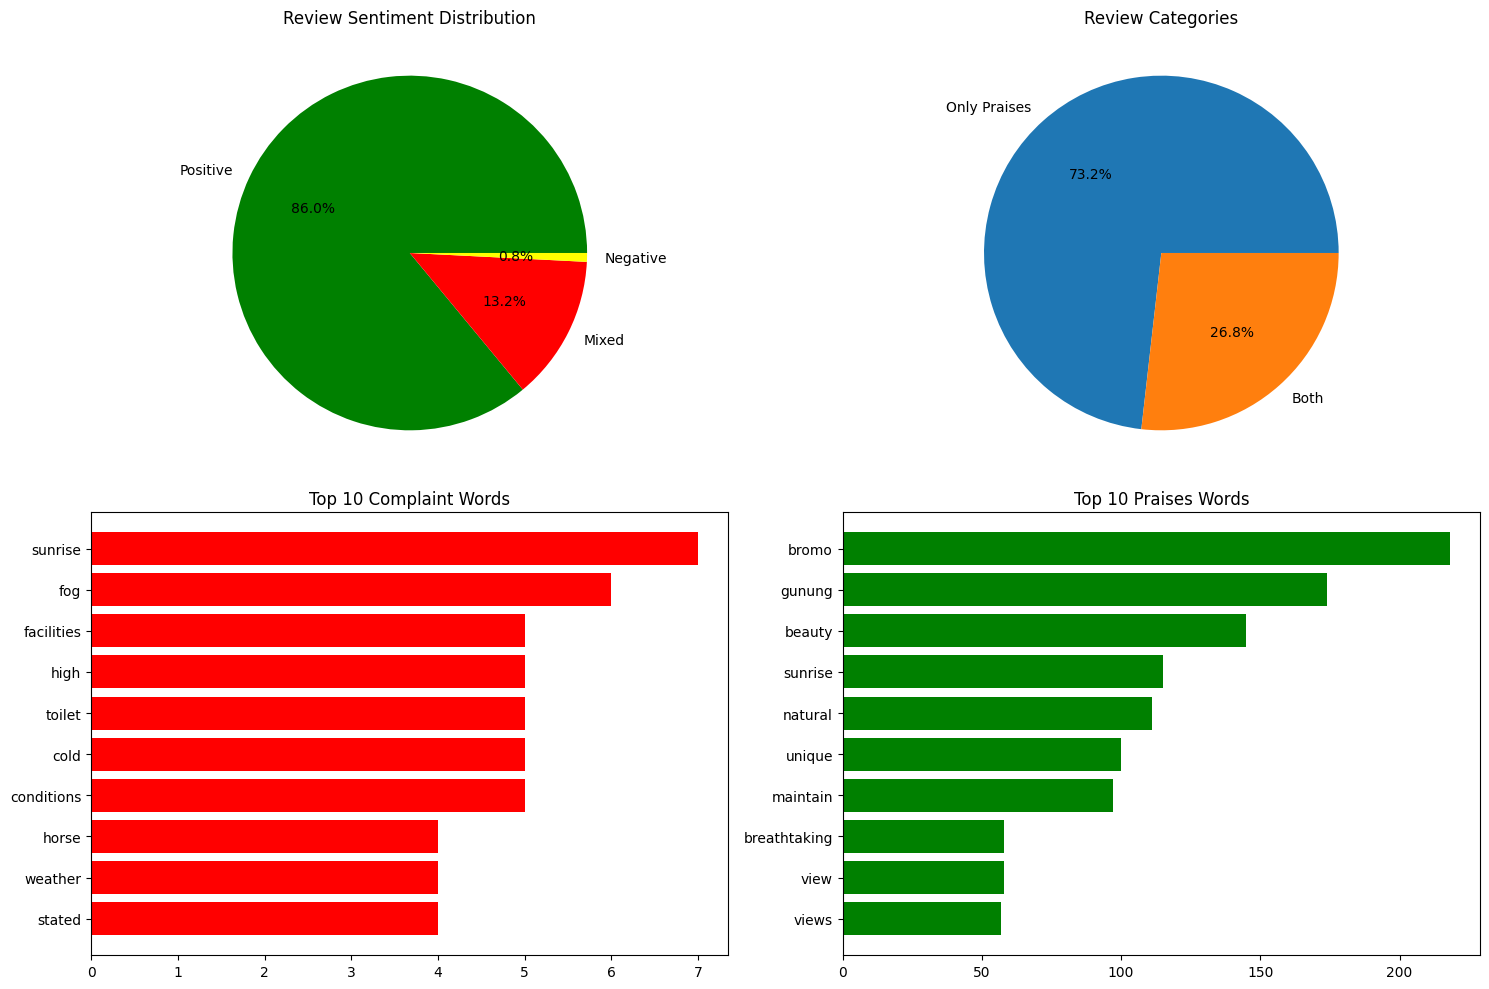

In [86]:
# Visualization
plt.figure(figsize=(15, 10))

# Sentiment Pie Chart
plt.subplot(2, 2, 1)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'yellow'])
plt.title('Review Sentiment Distribution')

# Category Pie Chart
plt.subplot(2, 2, 2)
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Review Categories')

# Top Complaints Bar Chart
plt.subplot(2, 2, 3)
complaint_words, complaint_counts = zip(*top_complaints)
plt.barh(complaint_words, complaint_counts, color='red')
plt.title('Top 10 Complaint Words')
plt.gca().invert_yaxis()

# Top Complaints Bar Chart
plt.subplot(2, 2, 4)
praises_words, praises_counts = zip(*top_praises)
plt.barh(praises_words, praises_counts, color='green')
plt.title('Top 10 Praises Words')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()